# Fixpoint Quantization and Overflow #
## Theory ##

This notebook shows how to (re-)quantize signals in Python using

- pyfda_fix_lib (numpy)
- migen
- nMigen


In [1]:
import os, sys
import time

module_path = os.path.abspath(os.path.join('..')) # append directory one level up to import path
if module_path not in sys.path:  # ... if it hasn't been appended already
    sys.path.append(module_path)

    import dsp_nmigen.pyfda_fix_lib as fx
%matplotlib inline    

import matplotlib.pyplot as plt

plt.style.use('script.mplstyle')
import numpy as np

figsize = {"figsize":(13,7)}

### Increasing the wordlength

Before adding two fixpoint numbers their binary points need to be aligned, i.e. they need to have the same number of integer and fractional bits. This can be achieved by extending integer and / or fractional part. 

The value of a fixpoint number doesn't change when zeros are appended to the fractional part (for positive and negative numbers) so that part is easy. 

Prepending zeros to the integer part would change the sign of a negative number. Instead, the integer part is extended with copies of the sign bit, also called **sign extension**.

<img src="img/requant_extension.png" alt="drawing" width="50%"/> 

### Reduce the number of fractional bits

The problem of reducing the number of fractional places is well known from the decimal system. Different methods have been developed to achieve this like rounding, truncation, see e.g. https://www.eetimes.com/an-introduction-to-different-rounding-algorithms for more details than you'll ever need.
 
<figure>
    <img src='img/requant_reduce_fractional.png' alt='' width='80%'/>
    <figcaption>Fig. x: Reduction of fractional wordlength</figcaption>
</figure>

## pyfda_fix_lib

This section uses and describes the fixpoint library `dsp_lib_fix.py`. A quantizer is constructed as an instance of the class `Fixed()`, its properties are configured with a quantization dict `Q = fx.Fixed(q_dict)`. The quantization dict (in this case `q_dict`) sets the format `QI.QF` at the output of the quantizer and its quantization and overflow behaviour with the following keys:

- **'WI'**   : number of integer bits (integer)
- **'WF'**   : number of fractional bits (integer)
- **'quant'**: requantization behaviour (**'floor'**, 'round', 'fix', 'ceil', 'rint', 'none')
- **'ovfl'** : overflow behaviour (**'wrap'**, 'sat', 'none')
- **'frmt'** : number base / format for output (**'float'**, 'dec', 'bin', 'hex', 'csd'). Non-floats are scaled with 'scale'
- **'scale'**: float or a keyword; the factor between the fixpoint integer representation (FXP) and the real world value (RWV), RWV = FXP / scale. By default, scale = 1 << WI.  If ``scale`` is a float, this value is used. 

     **Examples:**
    
     ```
     WI.WF = 3.0, FXP = "b0110." = 6,   scale = 8 -> RWV = 6 / 8   = 0.75
     WI.WF = 1.2, FXP = "b01.10" = 1.5, scale = 2 -> RWV = 1.5 / 2 = 0.75
     ```
     
     Alternatively, if:

     - ``q_obj['scale'] == 'int'``:   `scale = 1 << self.WF`

     - ``q_obj['scale'] == 'norm'``:  `scale = 2.**(-self.WI)`      


`?fx.Fixed` shows the available options.

### Example

In [2]:
q_dict = {'WI':0, 'WF': 3,                 # number of integer and fractional bits
          'quant':'floor', 'ovfl': 'wrap'} # quantization and overflow behaviour
Q = fx.Fixed(q_dict)                       # instance of fixpoint class Fixed()
for i in np.arange(12)/10:                 # i = 0, 0.1, 0.2, ...
    print("q<{0:>3.2f}> = {1:>5.3f}".format(i, Q.fixp(i))) # quantize i
# uncomment to show documentation
# ?fx.Fixed 

q<0.00> = 0.000
q<0.10> = 0.000
q<0.20> = 0.125
q<0.30> = 0.250
q<0.40> = 0.375
q<0.50> = 0.500
q<0.60> = 0.500
q<0.70> = 0.625
q<0.80> = 0.750
q<0.90> = 0.875
q<1.00> = -1.000
q<1.10> = -1.000


### Signal Quantization
A sine signal $s(t)$ is quantized in the code below. The plot shows $s(t)$, the quantized signal $s_Q(t)$ the difference between both signals, the quantization error $\epsilon(t)$.

Overflows:	2200
Run time:	1.56 ms for 10000 quantizations



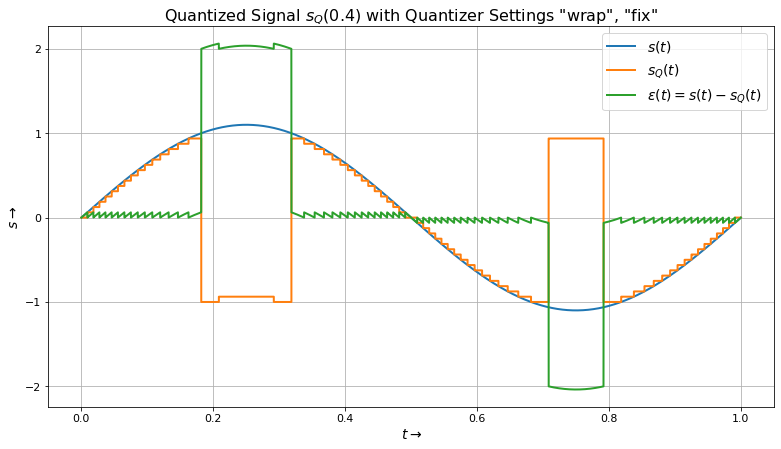

In [3]:
N = 10000; f_a = 1
t = np.linspace(0, 1, N, endpoint=False)
s = 1.1 * np.sin(2 * np.pi * f_a * t)
#
q_dict = {'WI':0, 'WF': 4, 'quant':'fix', 'ovfl': 'wrap'} # also try 'round' ; 'sat'
Q = fx.Fixed(q_dict) # quantizer instance with parameters defined above

t_cpu = time.perf_counter()

sq = Q.fixp(s) # quantize s
print('Overflows:\t{0}'.format(Q.N_over))
print('Run time:\t{0:.3g} ms for {1} quantizations\n'.format((time.perf_counter()-t_cpu)*1000, Q.N))
#
fig1, ax1 = plt.subplots(**figsize)
ax1.set_title('Quantized Signal $s_Q$({0}.{1}) with Quantizer Settings "{2}", "{3}"'.format(Q.WI, Q.WF, Q.ovfl, Q.quant))
ax1.plot(t, s, label = r'$s(t)$', lw=2)
ax1.step(t, sq, where = 'post', label = r'$s_Q(t)$', lw=2)
ax1.plot(t, s-sq, label = r'$\epsilon(t) = s(t) - s_Q(t)$', lw=2)
ax1.legend(fontsize = 14)
ax1.grid(True)
ax1.set_xlabel(r'$t \rightarrow$'); ax1.set_ylabel(r'$s \rightarrow$');
#

### Transfer Function of the Quantizer
The transfer function of the quantizer shows the quantized signal $s_Q(t)$ over the input signal $s(t)$ (a ramp). The advantage ove reusing the sine from the previous cell is that the input range can be taylored more easily and that the step size is constant.

Overflows:	4844


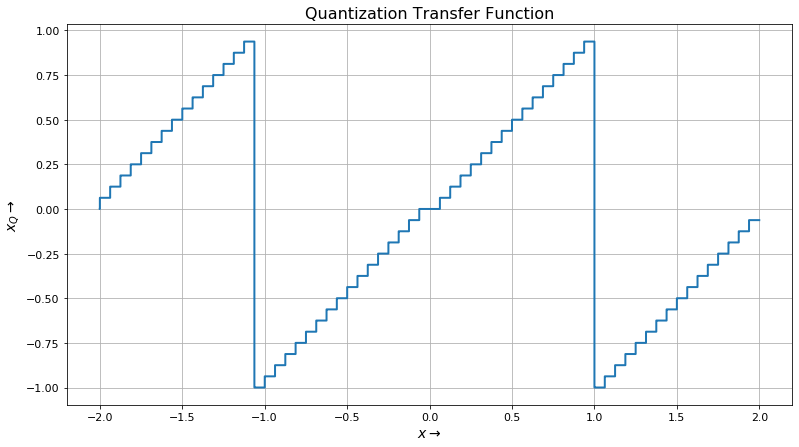

In [4]:
Q.resetN()    # reset overflow counter
x = np.linspace(-2, 2, N, endpoint=False) # generate ramp signal
xq = Q.fixp(x) # quantize x
print('Overflows:\t{0}'.format(Q.N_over))
fig2, ax2 = plt.subplots(**figsize); ax2.grid(True)
ax2.set_title('Quantization Transfer Function')
ax2.step(x,xq, where = 'post')
ax2.set_xlabel(r'$x \rightarrow$'); ax2.set_ylabel(r'$x_Q \rightarrow$');

### Number bases and formats
Quantized values can be printed in different number bases, e.g. as a binary string:

In [5]:
q_dict_f = {'WI':0, 'WF': 8,               # number of ingeger and fractional bits
          'quant':'floor', 'ovfl': 'wrap', # quantization and overflow behaviour
          'frmt':'bin'}                    # output format
Q1 = fx.Fixed(q_dict_f)                    # instance of fixpoint class Fixed()
for i in np.arange(12)/10:                 # i = 0, 0.1, 0.2, ...
    print("q<{0:>3.2f}> = {1}".format(i, Q1.float2frmt(Q1.fixp(i)))) # quantize i + display it in the wanted format

q<0.00> = 0.00000000
q<0.10> = 0.00011001
q<0.20> = 0.00110011
q<0.30> = 0.01001100
q<0.40> = 0.01100110
q<0.50> = 0.10000000
q<0.60> = 0.10011001
q<0.70> = 0.10110011
q<0.80> = 0.11001100
q<0.90> = 0.11100110
q<1.00> = 1.00000000
q<1.10> = 1.00011001


### Format Conversion
Numbers can also be converted back to floating with the method `frmt2float()`:

In [6]:
Q0 = fx.Fixed({'Q':'3.8', 'quant':'round', 'ovfl':'wrap', 'frmt':'bin'}) # direct setting of quantization options, use 'Q' instead of 
Q1_dict = Q0.q_obj        # read out Q0 quantization dict
Q1_dict.update({'WI':1, 'WF':5})  # update dict
Q1 = fx.Fixed(Q1_dict)    # and create a new quantizer instance with it      
frmt_str = "0.0x11"
x_org = Q0.frmt2float(frmt_str)
x_q = Q1.frmt2float(frmt_str)
print("q<b{0}> = {1} -> b{2} = {3}".format(frmt_str, x_org, 
                        Q1.float2frmt(x_q), x_q))

q<b0.0x11> = 0.375 -> b00.01100 = 0.375


Bug ?: Illegale Zeichen im frmt String führen bei frmt2float nicht zu Fehler, sondern werden ignoriert.

## migen ##
Some of the functionality above has been implemented in the migen `resize()` function.

Run time:	1.12e+03 ms for 10000 quantizations



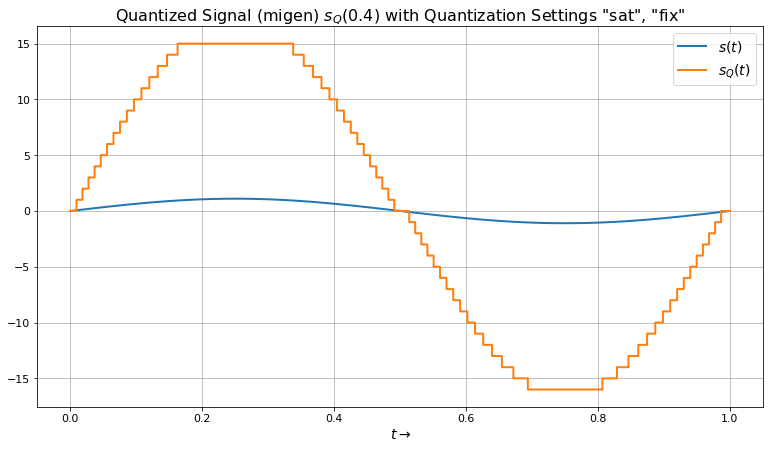

In [7]:
from migen import Signal, Module, run_simulation
from migen.fhdl import verilog
from dsp_migen.requant import requant
qI_dict = {'WI':1, 'WF': 5, 'quant':'fix', 'ovfl': 'sat'} # input quantization dict ('quant' and 'sat' settings are not used here)
qO_dict = {'WI':0, 'WF': 4, 'quant':'fix', 'ovfl': 'sat'} # output quantization dict

class Quant_migen(Module):
    """ This module only demonstrates the resize function. """
    def __init__(self):
        # ------------- Define I/Os -------------------------------------------
        self.i = Signal((qI_dict['WI'] + qI_dict['WF'] + 1, True)) # signed input signal
        self.o = Signal((qO_dict['WI'] + qO_dict['WF'] + 1, True)) # output signal

        # resize from input to output format
        self.comb += self.o.eq(requant(self, self.i, qI_dict, qO_dict))

Q1 = Quant_migen() # instantiate migen object

def tb(stimulus,  outputs):
    """ testbench generator with a stimulus list as input to migen module """
    for x in stimulus:
        yield Q1.i.eq(int(x)) # pass one stimulus value to filter
        outputs.append((yield Q1.o)) # append filter output to output list
        yield # next x until stimulus is processed

sq_mig = [] # initialize list for response
# initialize testbench generator; stimulus and response are integers!
# convert to float and back by dividing / multiplying with 2 ** WF
testbench = tb(s*2**qI_dict['WF'], sq_mig)  # stimulus, response
        
# uncomment to generate verilog
# print(verilog.convert(Q1, ios={Q1.i, Q1.o}))

t_cpu = time.perf_counter()
run_simulation(Q1, testbench) # run_simulation expects a migen module and a generator
print('Run time:\t{0:.3g} ms for {1} quantizations\n'.format((time.perf_counter()-t_cpu)*1000, Q.N))
#
fig3, ax3 = plt.subplots(**figsize); ax3.grid(True)
ax3.set_title('Quantized Signal (migen) $s_Q$({0}.{1}) with Quantization Settings "{2}", "{3}"'\
              .format(qO_dict['WI'], qO_dict['WF'], qO_dict['ovfl'], qO_dict['quant']))
ax3.plot(t, s, label = r'$s(t)$', lw=2)
ax3.step(t, sq_mig, where = 'post', label = r'$s_Q(t)$', lw=2)
#ax3.plot(t, s-sq_mig, label = r'$\epsilon(t) = s(t) - s_Q(t)$', lw=2)
ax3.legend(fontsize = 14)
ax3.set_xlabel(r'$t \rightarrow$'); ax1.set_ylabel(r'$s \rightarrow$');

***
### Copyright

(c) 2016 - 2020 Christian Münker 

This notebook is provided as [Open Educational Resource](https://en.wikipedia.org/wiki/Open_educational_resources) , feel free to use it for your own purposes. Please attribute the work as follows: *Christian Münker, dsp_migen documentation*.